(351, 351)
(315, 315)


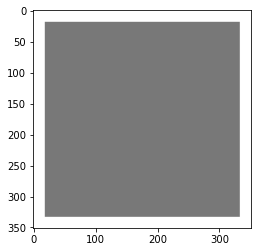

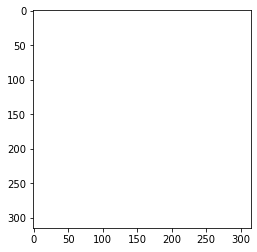

In [8]:
# load and show an image with Pillow
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import matplotlib.patches as mpatches
from numpy import asarray
import numpy
import cv2 as cv
import math
from scipy import signal

# Open the image form working directory
parent_image = Image.open('../top_view_images/cube_container_01_large.png')
child_image = Image.open('../top_view_images/cube_01_large.png')

# summarize some details about the shapes
print(parent_image.size)
print(child_image.size)

# show the parent image
pyplot.imshow(parent_image)
pyplot.show()

# show the child image
pyplot.imshow(child_image)
pyplot.show()

In [2]:
# Is parent container ?
def is_container(object_image):
    object_np = asarray(object_image)
    print(object_np.shape)

    object_np = numpy.where(object_np < 100, 0, object_np)
    object_np = numpy.where((object_np >= 100) & (object_np < 230), 120, object_np)
    object_np = numpy.where(object_np >= 230, 255, object_np)

    u_values = numpy.unique(object_np[:, :, 1])
    print(u_values)
    if 120 in u_values:
        print("Object is container")
        return True
    else:
        print("Object is not a container")
        return False
is_container(parent_image)
is_container(child_image)


(351, 351, 3)
[  0 120 255]
Object is container
(315, 315, 3)
[255]
Object is not a container


False

In [9]:
def image2nptemplate(object_image, parent):
    object_np = asarray(object_image)
    print(object_np.shape)
    
    if parent:
        object_np = numpy.where(object_np < 100, 0, object_np)
        object_np = numpy.where((object_np >= 100) & (object_np < 230), 120, object_np)
        object_np = numpy.where(object_np >= 230, 255, object_np)
    else:
        object_np = numpy.where(object_np <= 250, 0, object_np)
        object_np = numpy.where(object_np > 250, 255, object_np)

    u_values = numpy.unique(object_np)
    print(u_values)
    if 120 in u_values:
        print("Object is container")
        object_np = numpy.where(object_np == 120, 1, 0)
        return object_np
    else:
        print("Object is not a container")
        object_np = numpy.where(object_np == 255, 1, 0)
        return object_np

In [4]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat





In [5]:
def create_parent_image(ori_parent_img, obj_in_img, dx, dy, theta, scale=117.2):
    # ori_parent_img: original top view from the template
    # obj_in_img: the object to be placed into the parent to create the image
    # dx: in 3D
    # dy: in 3D
    # theta: in 3D
    # scale: 3Dtopixel scale default 1.8m = 211 pixels -> 1m = 211/1.8 or 117.2
    ori_parent_img_clone = ori_parent_img.copy()
    obj_in_img_clone = obj_in_img.copy()
    di = - dx * scale
    dj = - dy * scale


    # Rotate obj_in_img to theta
    rot_obj_in_img_clone = rotate_image(obj_in_img_clone, theta)
    pyplot.imshow(obj_in_img_clone)
    pyplot.show()
    pyplot.imshow(rot_obj_in_img_clone)
    pyplot.show()

    # Overlay on top of the ori_parent_img_clone and move it to di and dj
    (row_p, col_p, d_p) = ori_parent_img_clone.shape
    (row_c, col_c, d_p) = rot_obj_in_img_clone.shape
    pix_i_left_top = int(col_p*0.5 - col_c*0.5 + di)
    pix_j_left_top = int(row_p*0.5 - row_c*0.5 + dj)

    print(col_p, row_p)
    print(col_c, row_c)
    print(pix_i_left_top, pix_j_left_top)
    for c in range(col_c):
        for r in range(row_c):
            k = rot_obj_in_img_clone[r, c]
            if k[0] > 0:
                ori_parent_img_clone[pix_j_left_top+r, pix_i_left_top+c] = k

    pyplot.imshow(ori_parent_img_clone)
    pyplot.show()
    cv.imwrite('../sample_overlayed_parent.png', ori_parent_img_clone)
    return ori_parent_img_clone

In [12]:
def preprocess_image_sizes(parent_im, child_im):
    #Find the diagonal pixels of the child_im
    (rows, cols, d) = child_im.shape
    diag_pixels = int(math.sqrt(rows ** 2 + cols ** 2))
    print(rows, cols)
    print(diag_pixels)

    (rows_p, cols_p, d_p) = parent_im.shape
    print(rows_p, cols_p)

    #Add pixels as buffer
    diag_pixels = diag_pixels + max(rows, cols) + 50

    if (diag_pixels > rows_p) or (diag_pixels > cols_p):
        #Create a blank image
        super_parent = numpy.zeros((diag_pixels, diag_pixels, d), numpy.uint8)
        (rows_sp, cols_sp, d_sp) = super_parent.shape
        print(rows_sp, cols_sp)

        #Add the parent to the center
        r_start = int(rows_sp * 0.5 - rows_p * 0.5)
        c_start = int(cols_sp * 0.5 - cols_p * 0.5)
        for r in range(rows_p):
            for c in range(cols_p):
                super_parent[r_start + r, c_start + c] = parent_im[r, c]

        pyplot.imshow(parent_im)
        pyplot.show()
        pyplot.imshow(super_parent)
        pyplot.show()

        return super_parent
    else:
        return parent_im

315 315
445
525 351
810 810


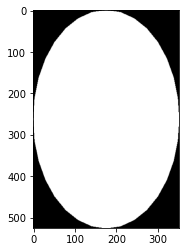

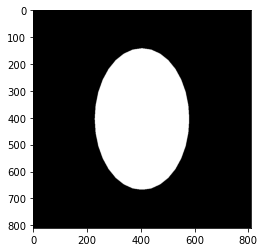

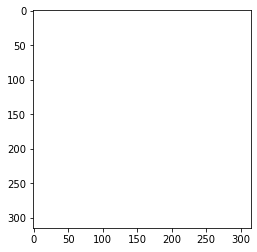

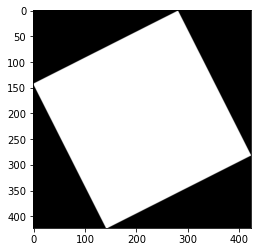

810 810
423 423
270 205


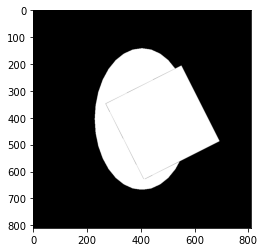

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [13]:
parent_image = cv.imread('../top_view_images/long_cylinder_01_large.png')
child_image = cv.imread('../top_view_images/cube_01_large.png')
parent_image = preprocess_image_sizes(parent_image, child_image)
create_parent_image(parent_image, child_image, -0.66, -0.104, 116.8)

In [14]:
def can_contain(parent_np, child_np, parent_image, child_image):
    parent_np = image2nptemplate(parent_image, True)
    child_np = image2nptemplate(child_image, False)


    parent_np = parent_np[:, :, 0]
    child_np = child_np[:, :, 0]
    print("Unique parent_np:", numpy.unique(parent_np))
    print("Unique child_np:",numpy.unique(child_np))


    match = numpy.sum(child_np)
    conv = signal.convolve2d(parent_np, 2*child_np[::-1, ::-1]-1, mode='valid')
    print(conv.shape)
    print(parent_np.shape)
    tst = abs(conv - match) < 1000
    # print(tst)
    candidates = numpy.argwhere(tst)
    print("Unique candidates:", candidates)
    if candidates.size >1:
        print("Can contain")
        pyplot.imshow(parent_image)
        rect=mpatches.Rectangle((candidates[0, 0],candidates[0, 1]),child_np.shape[1],child_np.shape[0],
                            #fill=False,
                            alpha=0.1,
                           facecolor="red")
        pyplot.gca().add_patch(rect)
        pyplot.show()
    else:
        print("Cannot contain")

[  0 120 255]
(449, 449, 3)
[  0   8  16  24  32  40  48  56  64  72  80  88  95  96 104 112 120 124
 128 133 135 137 141 143 145 150 151 154 158 159 162 166 167 169 171 175
 179 183 188 191 192 196 199 200 204 207 209 213 215 217 221 223 225 230
 231 234 238 239 242 243 247 251 255]
(385, 561, 3)
[  0 120 255]
Object is container
(449, 449, 3)
[  0 255]
Object is not a container


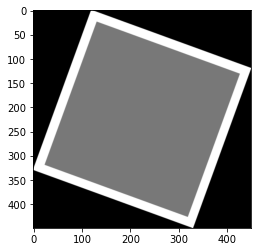

In [15]:
parent_image = cv.imread('../top_view_images/ellipse_container_01_large.png')
child_image = cv.imread('../top_view_images/cube_container_01_large.png')
print(numpy.unique(asarray(parent_image)))

# rotated_parent = rotate_image(parent_image, -60)
# print(rotated_parent.shape)
# print(numpy.unique(asarray(rotated_parent)))
# pyplot.imshow(rotated_parent)

rotated_child = rotate_image(child_image, -20)
print(rotated_child.shape)
print(numpy.unique(asarray(rotated_child)))
pyplot.imshow(rotated_child)
parent_np = image2nptemplate(parent_image, True)
child_np = image2nptemplate(rotated_child, False)

In [16]:
can_contain(parent_np, child_np, parent_image, child_image)

(385, 561, 3)
[  0 120 255]
Object is container
(351, 351, 3)
[  0 255]
Object is not a container
Unique parent_np: [0 1]
Unique child_np: [0 1]
(35, 211)
(385, 561)
Unique candidates: []
Cannot contain
